# ViewPhotoCalib from Calexp and CCD Visits for Auxtel


- Just read pandas dataframe and show plots

- author Sylvie Dagoret-Campagne
- creation date 2024-05-10
- last update 2024-05-10
- affiliation : IJCLab
- kernel : **w_2024_16**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time

In [3]:
import matplotlib.dates as mdates
#month_locator = mdates.MonthLocator(interval=1)
#day_locator = mdates.DayLocator(interval=1)
#year_month_formatter = mdates.DateFormatter("%Y-%m") 

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")





In [4]:
from lsst.daf.butler import Butler



# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collections = [collection]
collectionn = collection
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_photocalib = f"ccdVisittractpatch_{collectionStr}_calexpinfo.csv"
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"

suptitle = collectionStr + f" inst = {instrument} "

In [5]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4


## Read inputs

### Access CCD visit table

In [6]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985']


In [7]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [8]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [9]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43453134336    20240308
43453134592    20240308
43453134848    20240308
43453135104    20240308
43453135360    20240308
Name: nightObs, Length: 3993, dtype: int64

In [10]:
# get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [11]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [12]:
# select the missing quantities (the time)
ccd_visit_table_subset = ccd_visit_table[["Time","obsStart"]]

### Read pandas dataframe containing the tract-patch decomposition of visits

In [13]:

# need the visit file because observation date is missing
file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
df1 = pd.read_csv(file_selected_visits,index_col=0)

### Read the dataframe with the extracted parameters from calexp,calexpBackground

In [14]:
df = pd.read_csv(fn_ccdVisit_photocalib,index_col=0)

In [15]:
df

,idx,visitId,ccdVisitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
0,0,2023051100262,40919696896,r,0,27.697306,1.823818,11.193549,7.856800,30.0,...,0.248366,0.225585,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486
1,1,2023051100264,40919697408,i,0,27.838850,1.762794,28.073927,8.586373,30.0,...,0.179049,0.156368,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220
2,2,2023051100268,40919698432,r,0,27.716720,1.721301,10.700970,7.854424,30.0,...,0.209981,0.178780,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189
3,3,2023051100270,40919698944,i,0,27.858833,1.695170,23.952974,8.440454,30.0,...,0.153219,0.113119,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426
4,4,2023051100271,40919699200,i,0,27.826286,1.677014,23.321407,8.416399,30.0,...,0.192677,0.186060,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,3988,2024030800566,43453134336,y,0,26.166447,1.628972,13.559249,8.029708,30.0,...,0.202783,0.201789,14.543334,13.834743,46.237755,8.162957,13.667352,13.673567,8.108834,8.098375
3989,3989,2024030800567,43453134592,g,0,27.953827,1.640791,3.249260,7.539632,30.0,...,0.142516,0.117727,5.681164,3.586035,163.094440,7.650507,3.375397,3.388649,7.612238,7.562252
3990,3990,2024030800568,43453134848,r,0,27.774017,1.646516,6.951125,7.735226,30.0,...,0.254764,0.301270,9.697268,7.358734,165.478010,7.867656,7.077890,7.080711,7.781153,7.740263
3991,3991,2024030800569,43453135104,z,0,27.314375,1.652293,16.513548,8.214679,30.0,...,0.224378,0.243762,18.859300,16.908672,134.290970,8.371975,16.612659,16.619394,8.255046,8.241149


In [16]:
df.set_index("ccdVisitId",inplace=True)

In [17]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,0,2023051100262,r,0,27.697306,1.823818,11.193549,7.856800,30.0,30.490464,...,0.248366,0.225585,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486
40919697408,1,2023051100264,i,0,27.838850,1.762794,28.073927,8.586373,30.0,25.507239,...,0.179049,0.156368,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220
40919698432,2,2023051100268,r,0,27.716720,1.721301,10.700970,7.854424,30.0,27.956394,...,0.209981,0.178780,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189
40919698944,3,2023051100270,i,0,27.858833,1.695170,23.952974,8.440454,30.0,26.273077,...,0.153219,0.113119,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426
40919699200,4,2023051100271,i,0,27.826286,1.677014,23.321407,8.416399,30.0,26.568090,...,0.192677,0.186060,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,3988,2024030800566,y,0,26.166447,1.628972,13.559249,8.029708,30.0,92.696186,...,0.202783,0.201789,14.543334,13.834743,46.237755,8.162957,13.667352,13.673567,8.108834,8.098375
43453134592,3989,2024030800567,g,0,27.953827,1.640791,3.249260,7.539632,30.0,23.385866,...,0.142516,0.117727,5.681164,3.586035,163.094440,7.650507,3.375397,3.388649,7.612238,7.562252
43453134848,3990,2024030800568,r,0,27.774017,1.646516,6.951125,7.735226,30.0,27.362185,...,0.254764,0.301270,9.697268,7.358734,165.478010,7.867656,7.077890,7.080711,7.781153,7.740263


## Add to the main dataframe df, the obstime found in ccd_visit_table

In [18]:
df = df.join(ccd_visit_table_subset)

In [19]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m,Time,obsStart
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,0,2023051100262,r,0,27.697306,1.823818,11.193549,7.856800,30.0,30.490464,...,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486,2023-05-12 01:08:41.302993,2023-05-12 01:08:41.302993
40919697408,1,2023051100264,i,0,27.838850,1.762794,28.073927,8.586373,30.0,25.507239,...,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220,2023-05-12 01:14:49.912000,2023-05-12 01:14:49.912000
40919698432,2,2023051100268,r,0,27.716720,1.721301,10.700970,7.854424,30.0,27.956394,...,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189,2023-05-12 01:19:24.311494,2023-05-12 01:19:24.311494
40919698944,3,2023051100270,i,0,27.858833,1.695170,23.952974,8.440454,30.0,26.273077,...,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426,2023-05-12 01:22:21.150002,2023-05-12 01:22:21.150002
40919699200,4,2023051100271,i,0,27.826286,1.677014,23.321407,8.416399,30.0,26.568090,...,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023,2023-05-12 01:24:32.058502,2023-05-12 01:24:32.058502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,3988,2024030800566,y,0,26.166447,1.628972,13.559249,8.029708,30.0,92.696186,...,14.543334,13.834743,46.237755,8.162957,13.667352,13.673567,8.108834,8.098375,2024-03-09 05:56:04.403505,2024-03-09 05:56:04.403505
43453134592,3989,2024030800567,g,0,27.953827,1.640791,3.249260,7.539632,30.0,23.385866,...,5.681164,3.586035,163.094440,7.650507,3.375397,3.388649,7.612238,7.562252,2024-03-09 05:57:46.104001,2024-03-09 05:57:46.104001
43453134848,3990,2024030800568,r,0,27.774017,1.646516,6.951125,7.735226,30.0,27.362185,...,9.697268,7.358734,165.478010,7.867656,7.077890,7.080711,7.781153,7.740263,2024-03-09 05:58:32.775498,2024-03-09 05:58:32.775498


## Additionnal processing

In [20]:
df["magzero_dt"] = df["magzero"].apply(lambda x : x+2.5*np.log10(30))
df["zeroPoint_diff"] = df["zeroPoint"]-df["magzero_dt"]

In [21]:
df.columns

Index(['idx', 'visitId', 'band', 'detector', 'zeroPoint', 'airmass', 'skyBg',
       'skyNoise', 'expTime', 'photocalib_m', 'photocalib_e', 'magzero',
       'magzero_rms', 'magzero_nobj', 'bgmean', 'bgvar', 'mu_ce', 'med_ce',
       'std_ce', 'sigMad_ce', 'mu_ce_m', 'med_ce_m', 'std_ce_m', 'sigMad_ce_m',
       'mu_bkg', 'med_bkg', 'std_bkg', 'sigMad_bkg', 'mu_bkg_m', 'med_bkg_m',
       'std_bkg_m', 'sigMad_bkg_m', 'mu_pisr', 'med_pisr', 'std_pisr',
       'sigMad_pisr', 'mu_pisr_m', 'med_pisr_m', 'std_pisr_m', 'sigMad_pisr_m',
       'Time', 'obsStart', 'magzero_dt', 'zeroPoint_diff'],
      dtype='object')

In [22]:
df["photocalib_mag"] = df["photocalib_m"].apply(convert_fluxtomag)

In [23]:
df["zeroPoint_photocalib_diff"] = df["zeroPoint"] - df["photocalib_mag"]
df["magzerodt_photocalib_diff"] = df["magzero_dt"] - df["photocalib_mag"]

## Split the dataframe in bands

In [24]:
df_g = df[df["band"] == 'g']
df_r = df[df["band"] == 'r']
df_i = df[df["band"] == 'i']
df_z = df[df["band"] == 'z']
df_y = df[df["band"] == 'y']

## Sky Background

### Sky Background in g band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

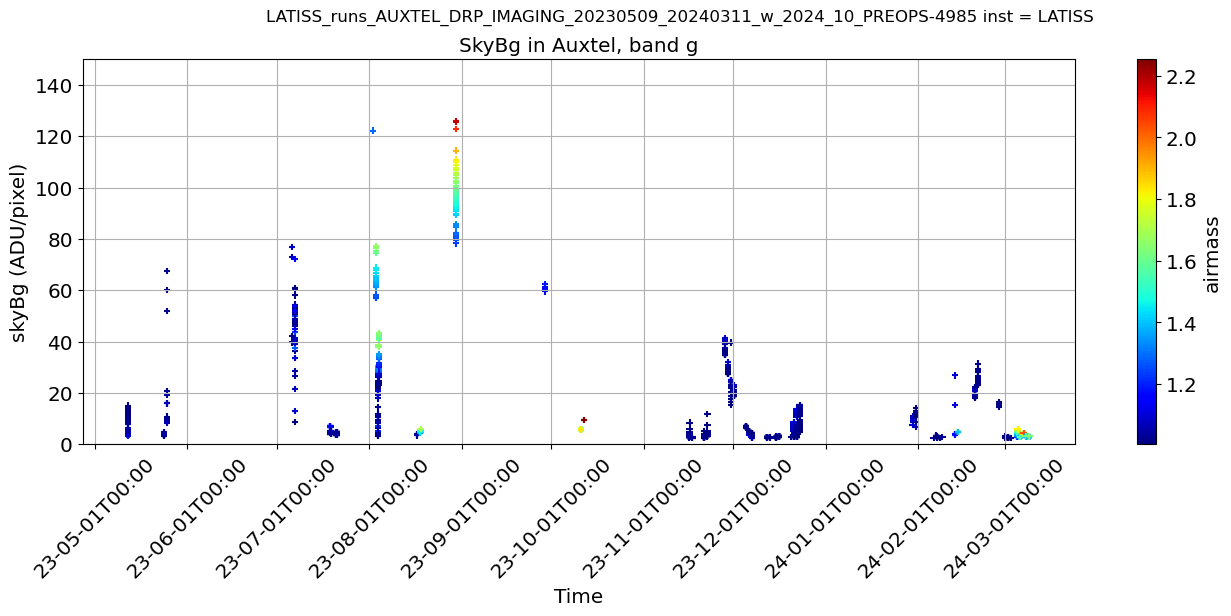

In [25]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band g"
df_g.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

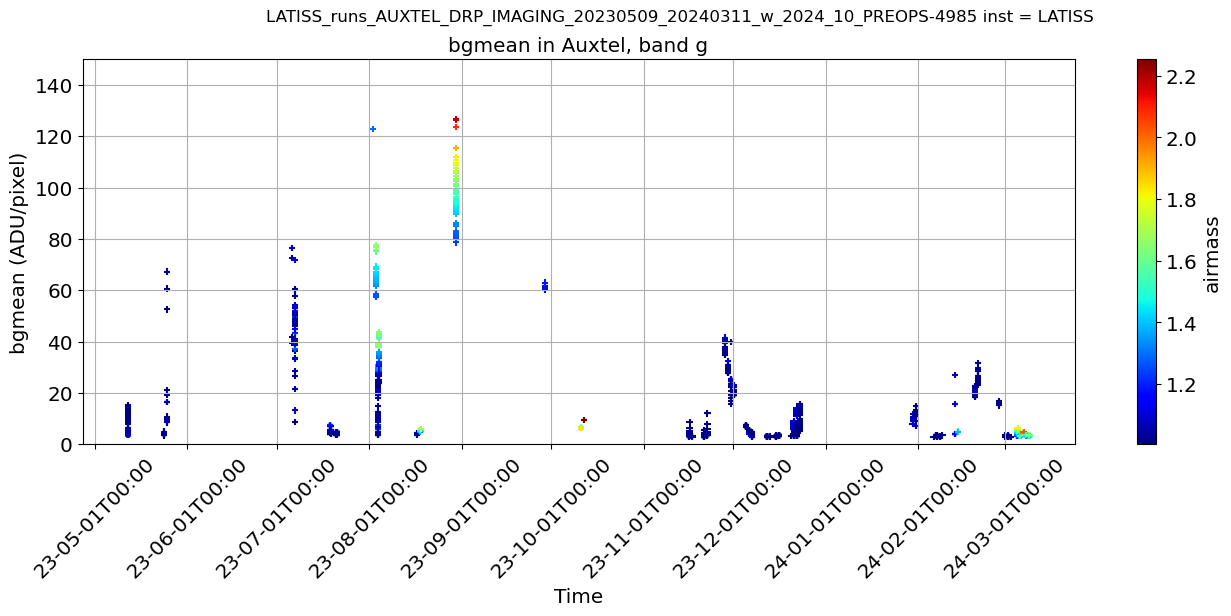

In [26]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"bgmean in Auxtel, band g"
df_g.plot.scatter(x="Time",y="bgmean",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="bgmean (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
plt.suptitle(suptitle)

/home/d/dagoret/.local/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

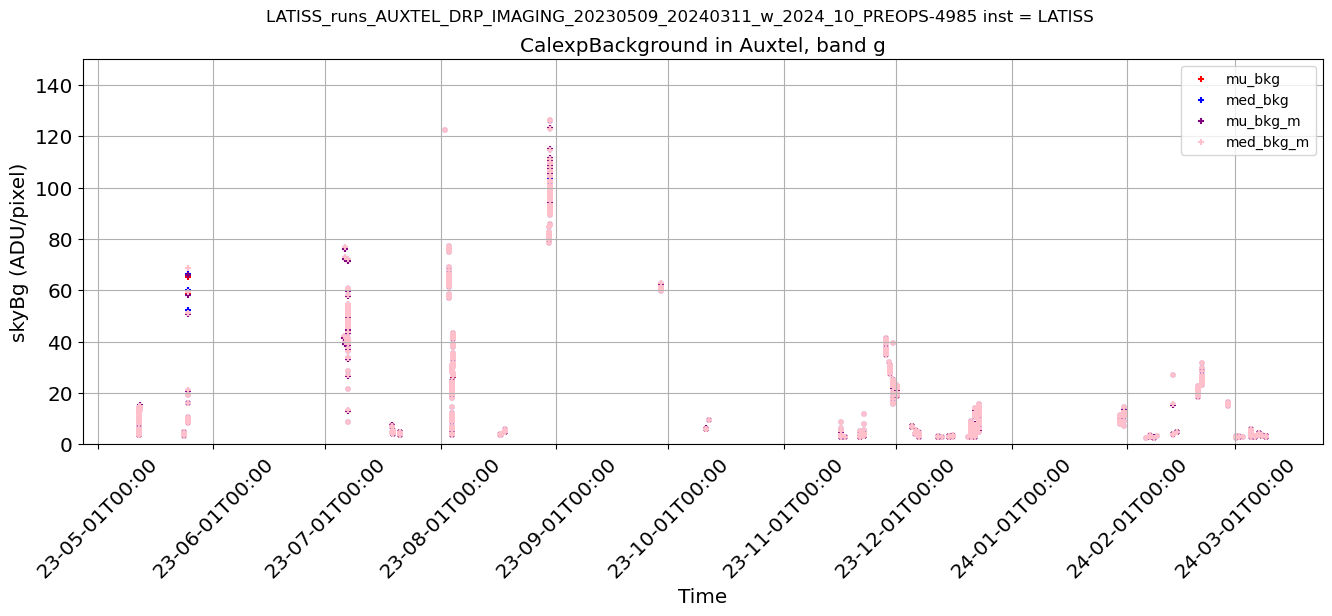

In [27]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"CalexpBackground in Auxtel, band g"
#mu_bkg', 'med_bkg', 'std_bkg', 'sigMad_bkg', 'mu_bkg_m', 'med_bkg_m',
df_g.plot.scatter(x="Time",y="mu_bkg",ax=ax,marker="+",c="r",rot=45,label="mu_bkg",ylabel="skyBg (ADU/pixel)",grid=True)
df_g.plot.scatter(x="Time",y="med_bkg",ax=ax,marker="+",c="b",rot=45,label="med_bkg",ylabel="skyBg (ADU/pixel)",grid=True)
df_g.plot.scatter(x="Time",y="mu_bkg_m",ax=ax,marker="+",c="purple",rot=45,label="mu_bkg_m",ylabel="skyBg (ADU/pixel)",grid=True)
df_g.plot.scatter(x="Time",y="med_bkg_m",ax=ax,marker="+",c="pink",rot=45,label="med_bkg_m",ylabel="skyBg (ADU/pixel)",grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
ax.set_title(title)
plt.suptitle(suptitle)

### Sky Background in r band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

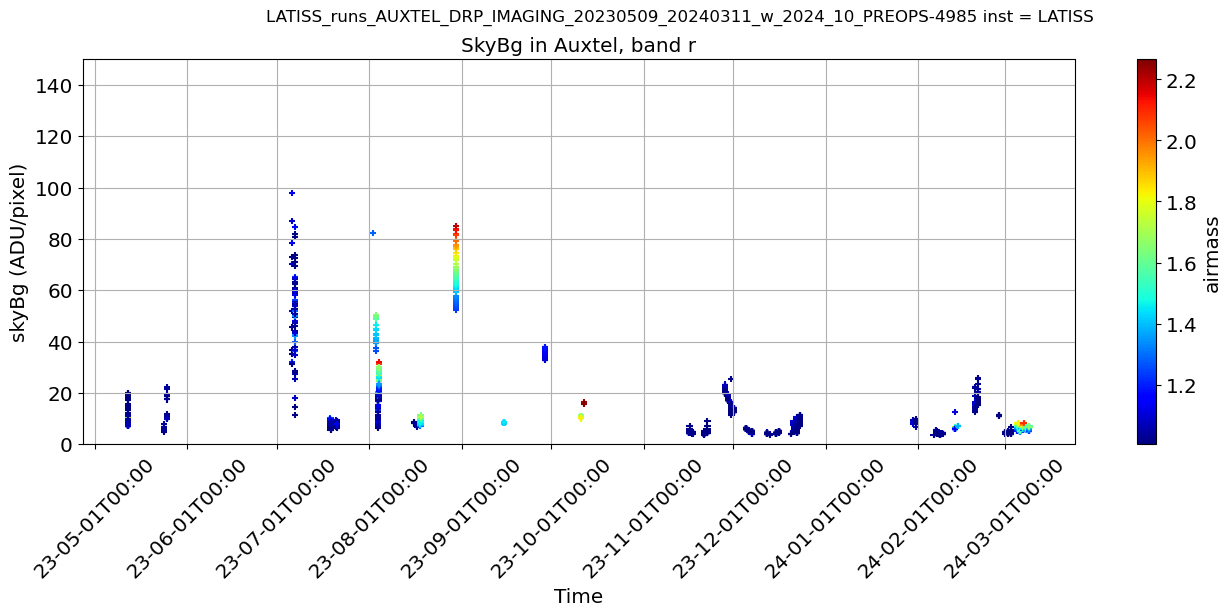

In [28]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band r"
df_r.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
plt.suptitle(suptitle)

### Sky Background in i band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

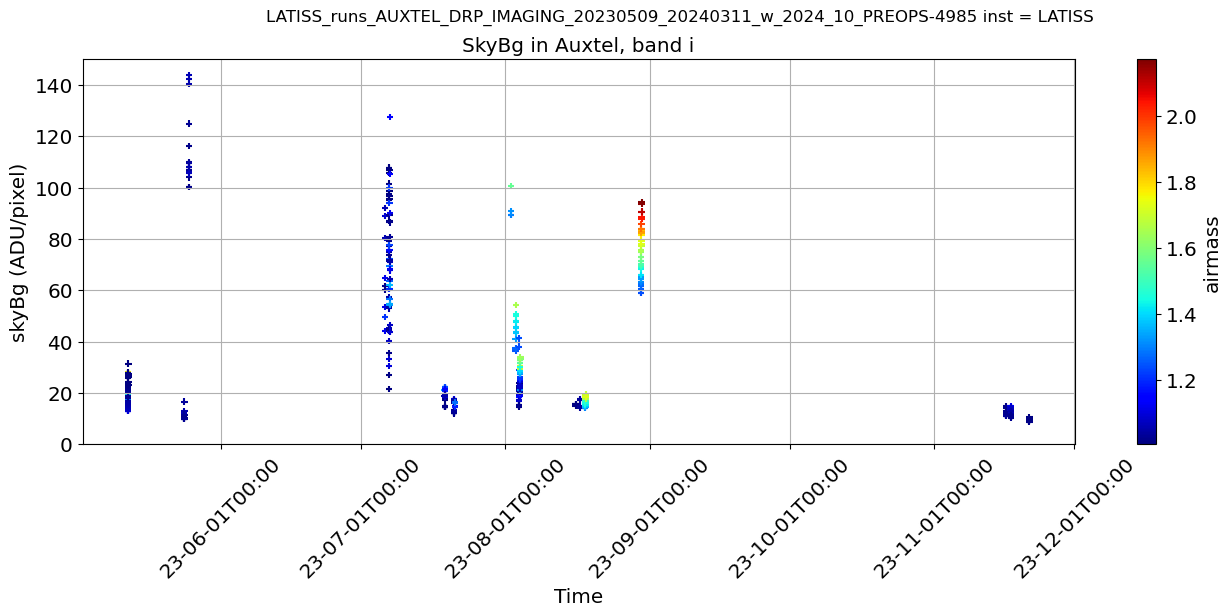

In [29]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band i"
df_i.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
plt.suptitle(suptitle)

### Sky Background in z band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

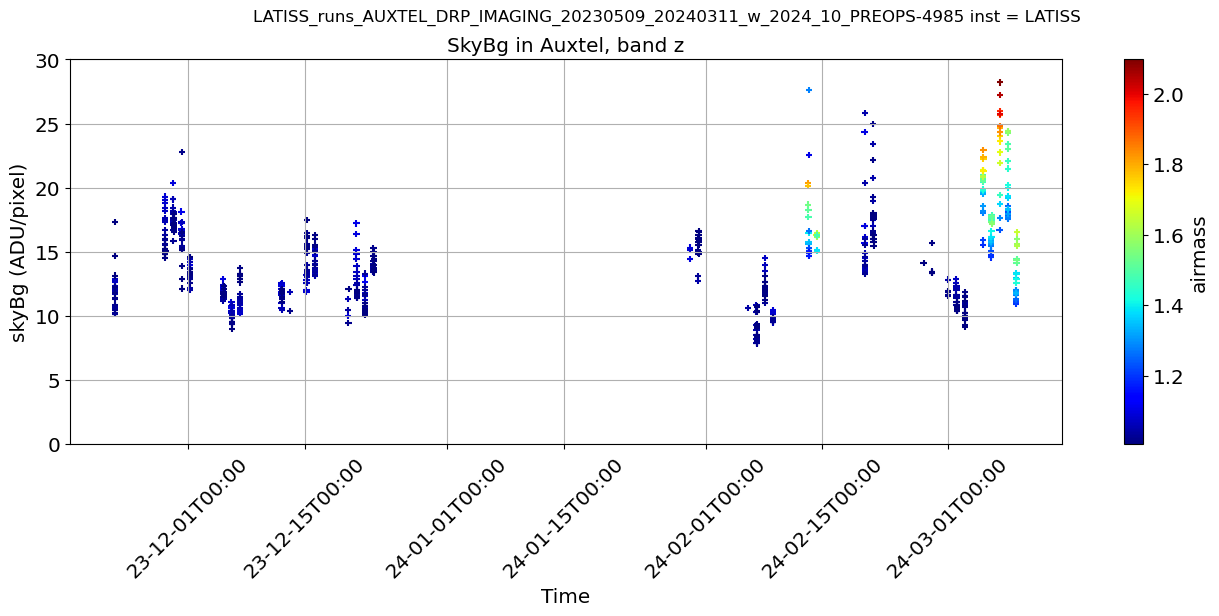

In [30]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band z"
df_z.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,30)
plt.suptitle(suptitle)

### Sky Background in y band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

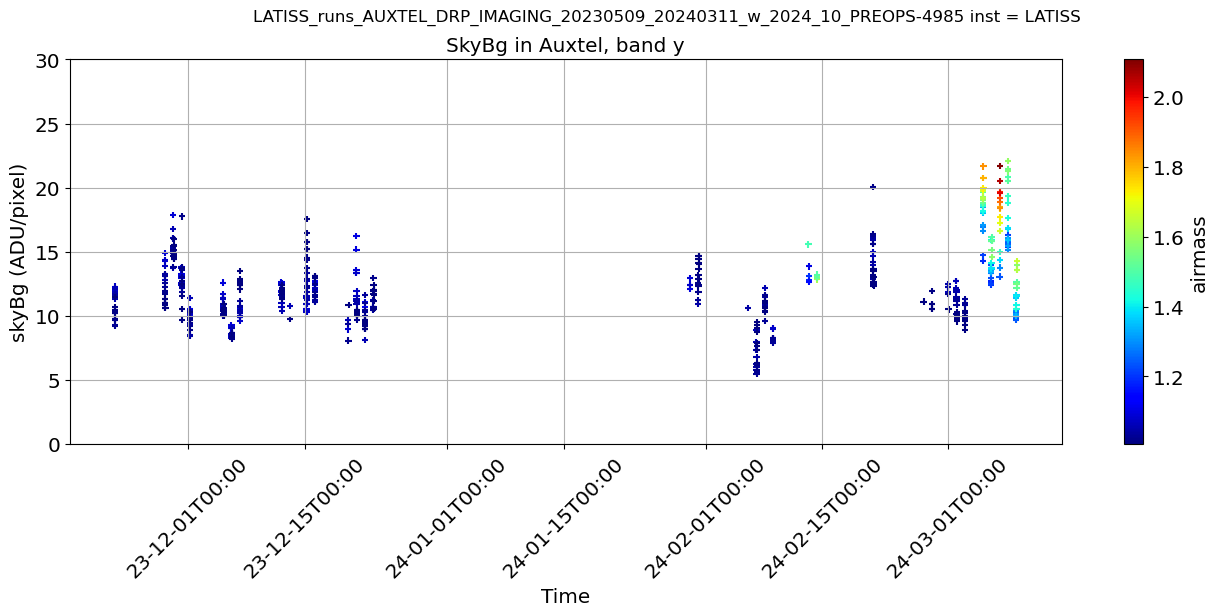

In [31]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band y"
df_y.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,30)
plt.suptitle(suptitle)

### Sky Noise

### Sky Noise in g band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

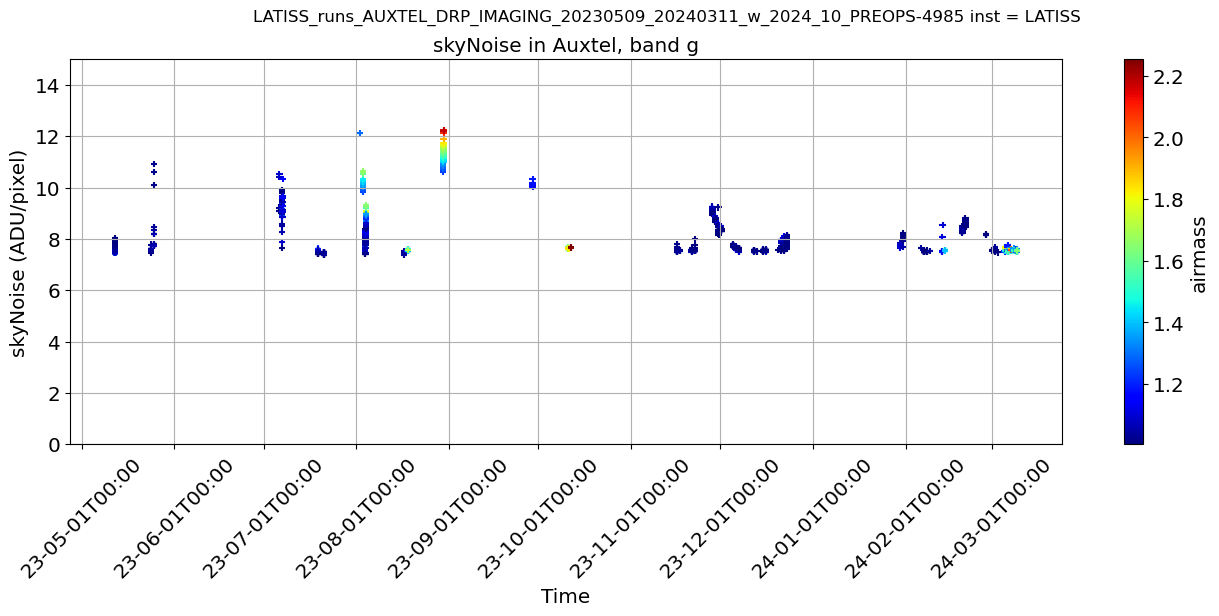

In [32]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"skyNoise in Auxtel, band g"
df_g.plot.scatter(x="Time",y="skyNoise",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyNoise (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,15.)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

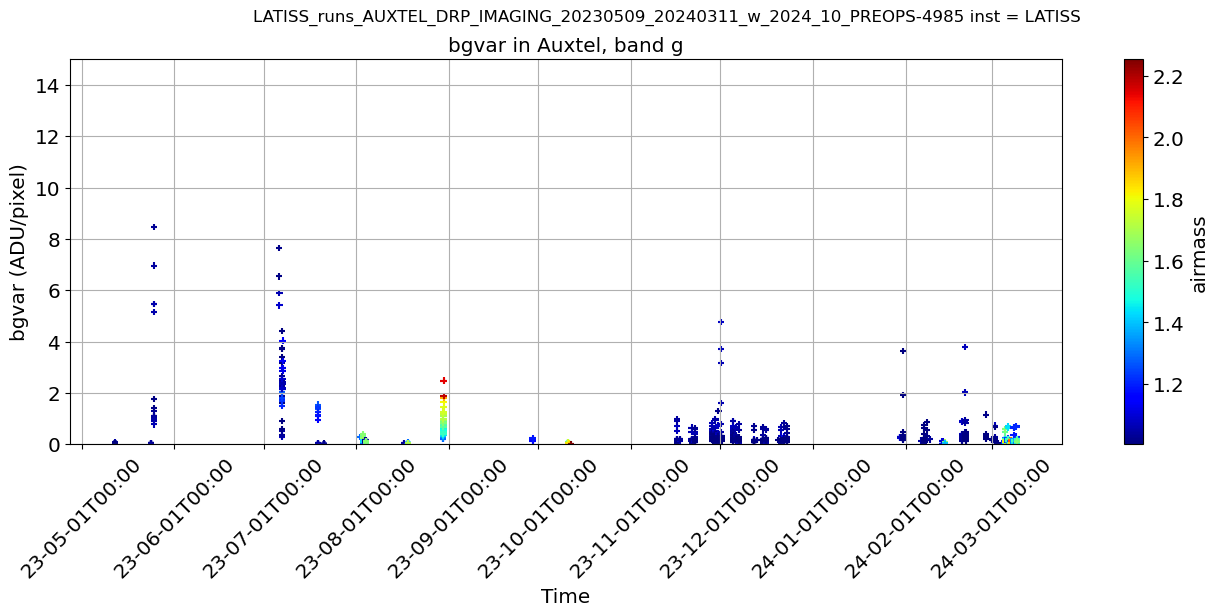

In [33]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"bgvar in Auxtel, band g"
df_g.plot.scatter(x="Time",y="bgvar",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="bgvar (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,15)
plt.suptitle(suptitle)

- sigma from mean absolute deviation in unmasked/ masked calexp

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

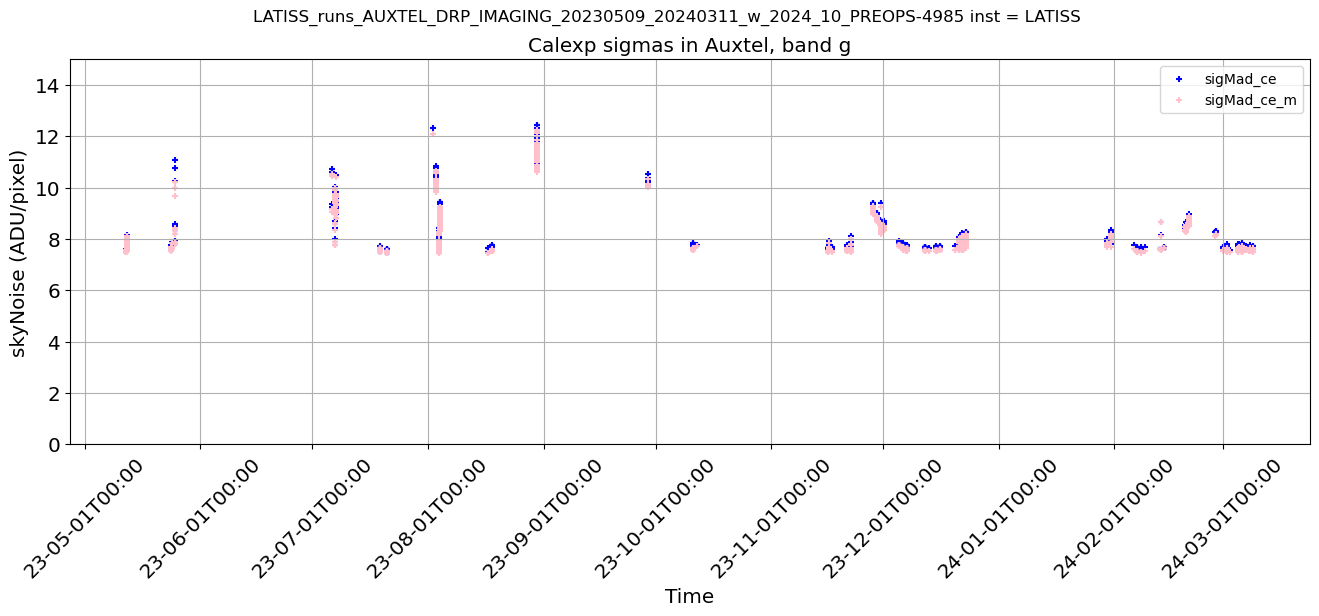

In [34]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"Calexp sigmas in Auxtel, band g"
#mu_bkg', 'med_bkg', 'std_bkg', 'sigMad_bkg', 'mu_bkg_m', 'med_bkg_m',
#df_g.plot.scatter(x="Time",y="std_ce",ax=ax,marker="+",c="r",rot=45,label="std_ce",ylabel="skyBg (ADU/pixel)",grid=True)
df_g.plot.scatter(x="Time",y="sigMad_ce",ax=ax,marker="+",c="b",rot=45,label="sigMad_ce",ylabel="skyNoise (ADU/pixel)",grid=True)
#df_g.plot.scatter(x="Time",y="std_ce_m",ax=ax,marker="+",c="purple",rot=45,label="std_ce_m",ylabel="skyBg (ADU/pixel)",grid=True)
df_g.plot.scatter(x="Time",y="sigMad_ce_m",ax=ax,marker="+",c="pink",rot=45,label="sigMad_ce_m",ylabel="skyNoise (ADU/pixel)",grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,15)
ax.set_title(title)
plt.suptitle(suptitle)

## Zero point

### Zero point in band g

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

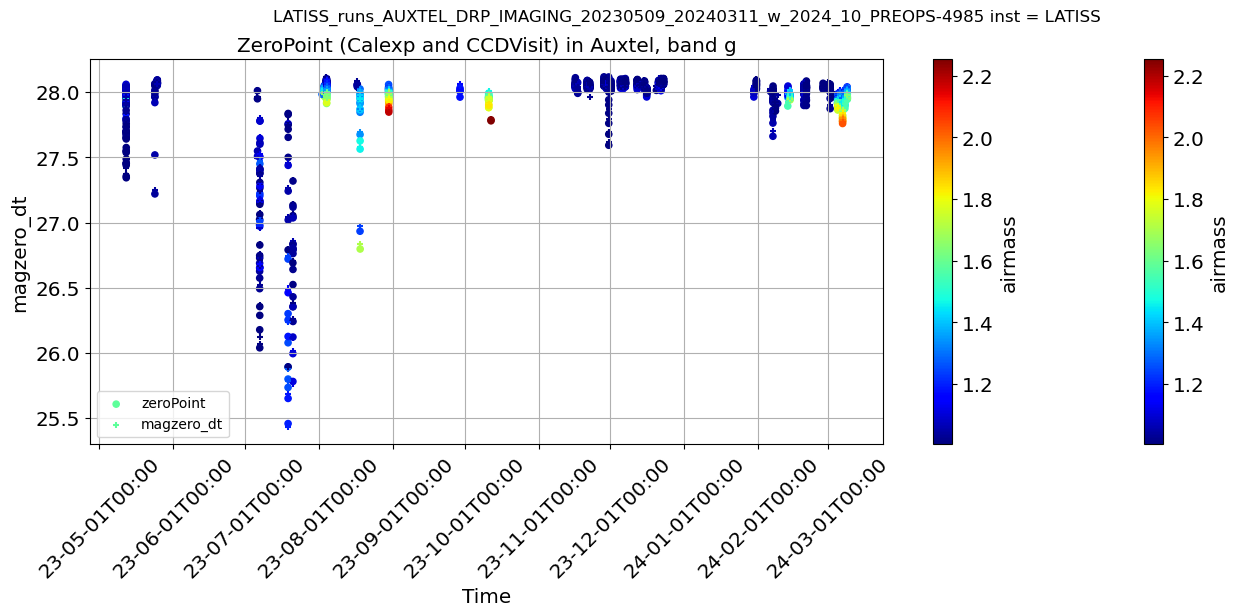

In [35]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint (Calexp and CCDVisit) in Auxtel, band g"
df_g.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
df_g.plot.scatter(x="Time",y="magzero_dt",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,label="magzero_dt",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

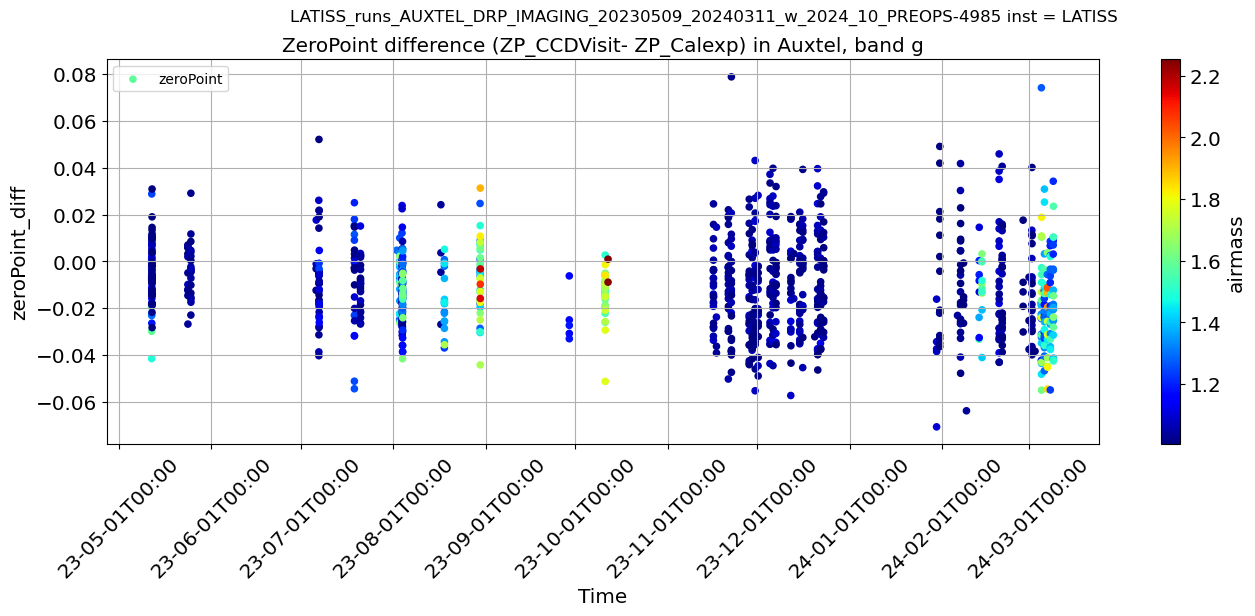

In [36]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_Calexp) in Auxtel, band g"
df_g.plot.scatter(x="Time",y="zeroPoint_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

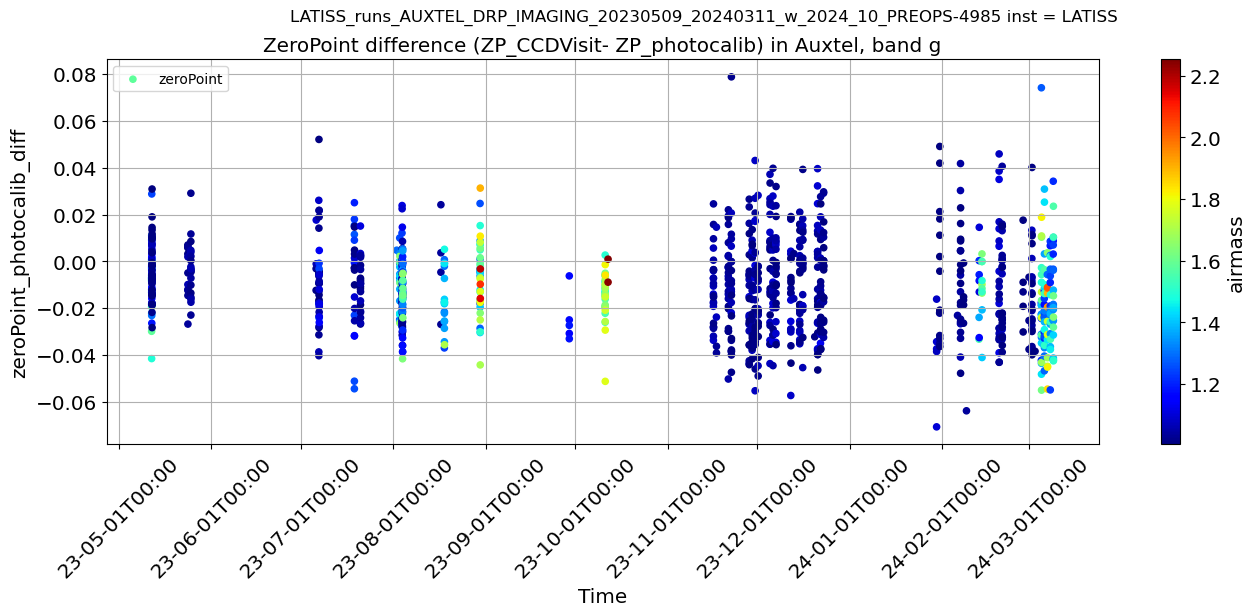

In [37]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band g"
df_g.plot.scatter(x="Time",y="zeroPoint_photocalib_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

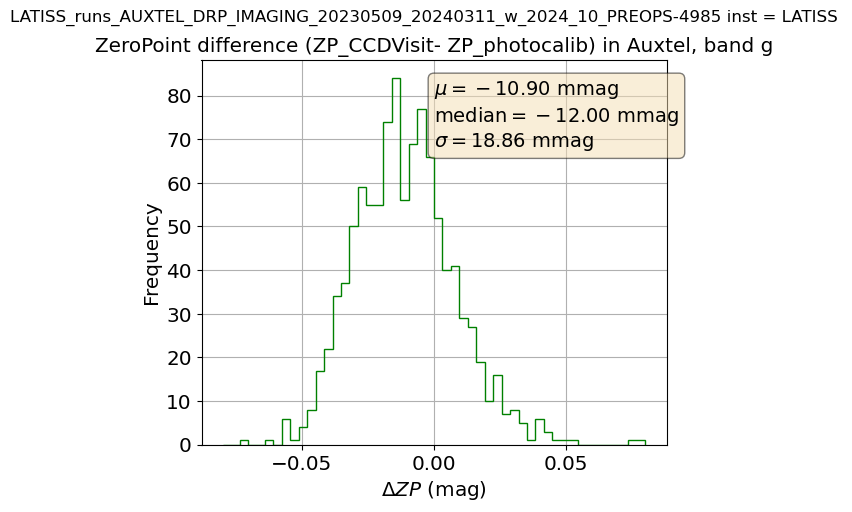

In [38]:

mu = df_g["zeroPoint_photocalib_diff"].mean()*1000
median = df_g["zeroPoint_photocalib_diff"].median()*1000
sigma = np.std(df_g["zeroPoint_photocalib_diff"].values-median)*1000
sigma_g = sigma
d_g= median

textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu, ),
    r'$\mathrm{median}=%.2f$ mmag' % (median, ),
    r'$\sigma=%.2f$ mmag' % (sigma, )))


fig, ax = plt.subplots(1,1,figsize=(6,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band g"
df_g["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.08,0.08),color='g',histtype="step",ax=ax,xlabel="$\Delta ZP$ (mag)",title=title,grid=True)
#ax.set_title(title)
ax.set_xlabel("$\Delta ZP$ (mag)")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.suptitle(suptitle)

- The following plot shows that magzero and photocalib are the same quantity derived from the photometric joint calibration of Calexp

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

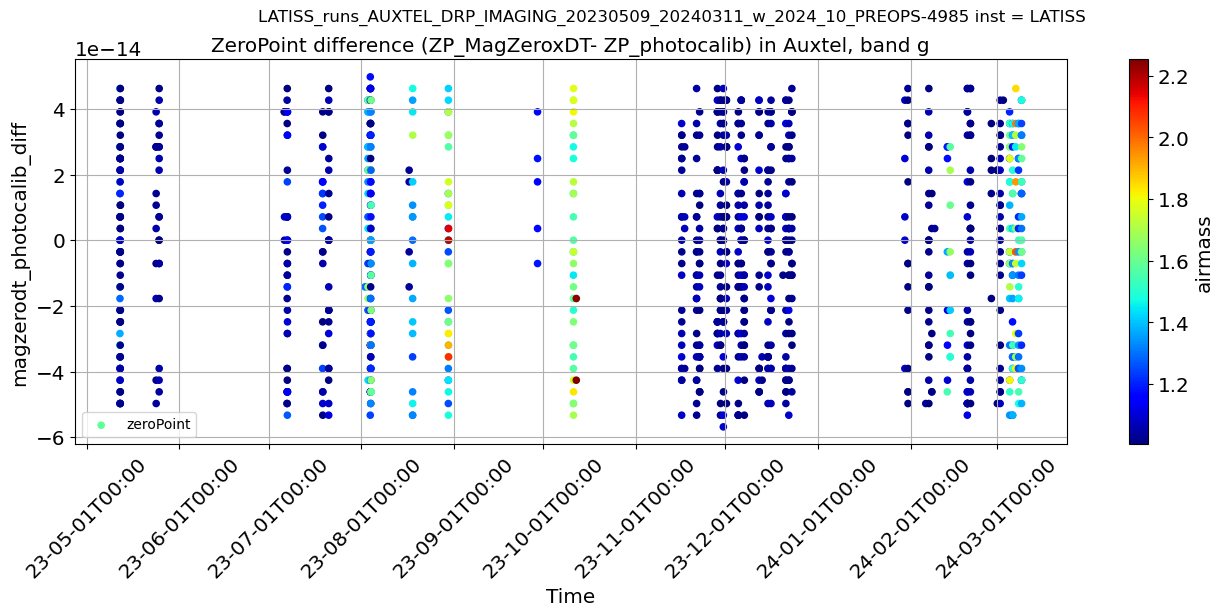

In [39]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_MagZeroxDT- ZP_photocalib) in Auxtel, band g"
df_g.plot.scatter(x="Time",y="magzerodt_photocalib_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

### Zero point in band r 

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

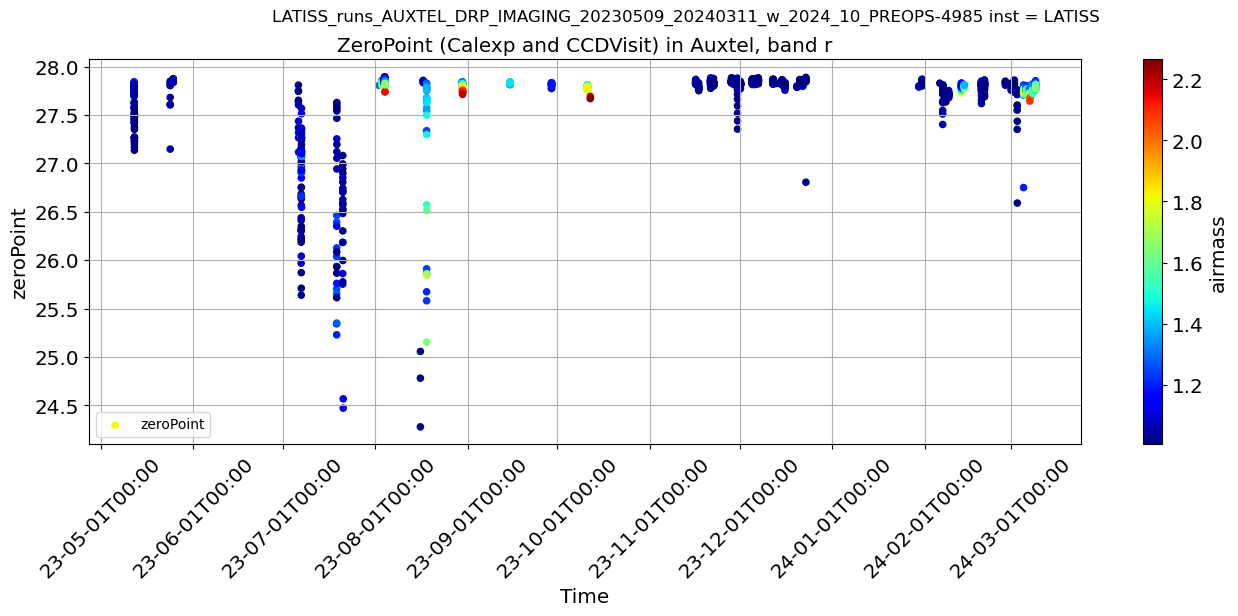

In [40]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint (Calexp and CCDVisit) in Auxtel, band r"
df_r.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
#df_r.plot.scatter(x="Time",y="magzero_dt",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,label="magzero_dt",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

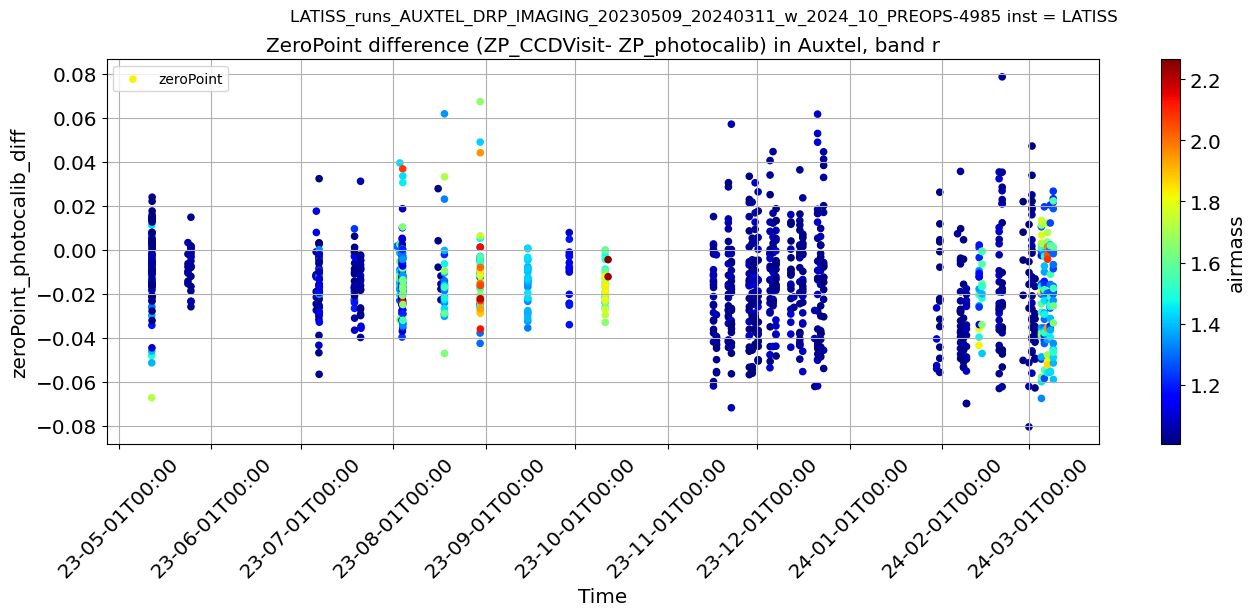

In [41]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band r"
df_r.plot.scatter(x="Time",y="zeroPoint_photocalib_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

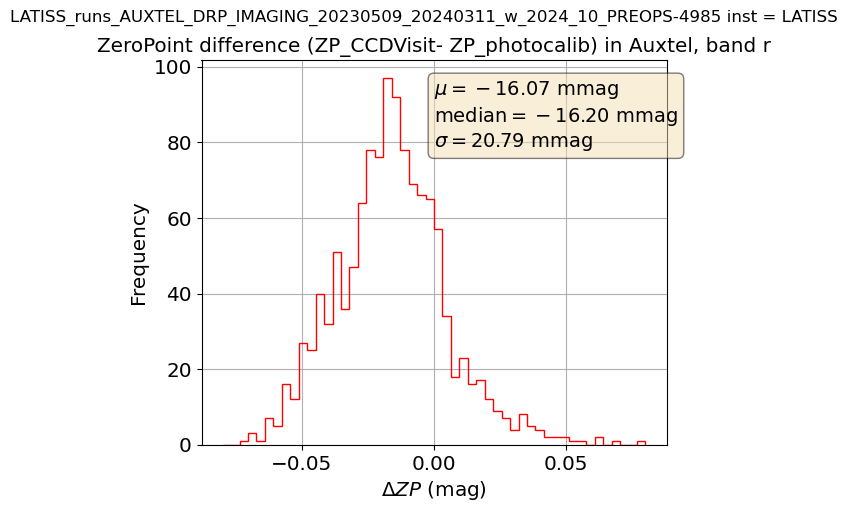

In [42]:

mu = df_r["zeroPoint_photocalib_diff"].mean()*1000
median = df_r["zeroPoint_photocalib_diff"].median()*1000
sigma = np.std(df_r["zeroPoint_photocalib_diff"].values-median)*1000
sigma_r = sigma
d_r= median
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu, ),
    r'$\mathrm{median}=%.2f$ mmag' % (median, ),
    r'$\sigma=%.2f$ mmag' % (sigma, )))


fig, ax = plt.subplots(1,1,figsize=(6,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band r"
df_r["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.08,0.08),color='r',histtype="step",ax=ax,xlabel="$\Delta ZP$ (mag)",title=title,grid=True)
#ax.set_title(title)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("$\Delta ZP$ (mag)")
plt.suptitle(suptitle)

### Zero point in i band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

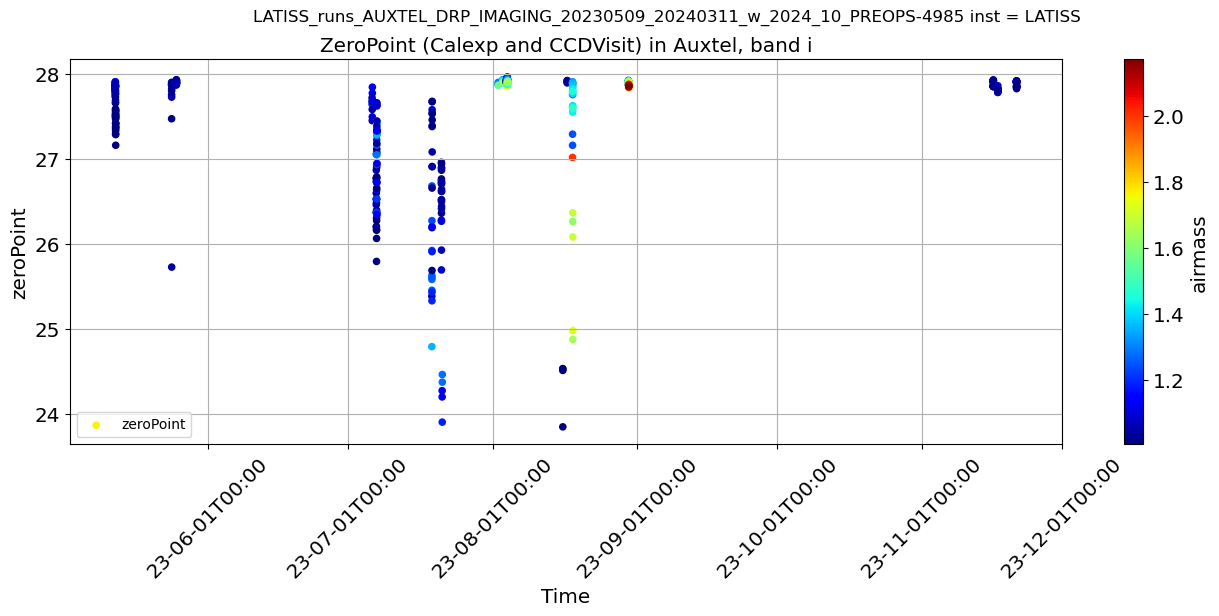

In [43]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint (Calexp and CCDVisit) in Auxtel, band i"
df_i.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
#df_r.plot.scatter(x="Time",y="magzero_dt",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,label="magzero_dt",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

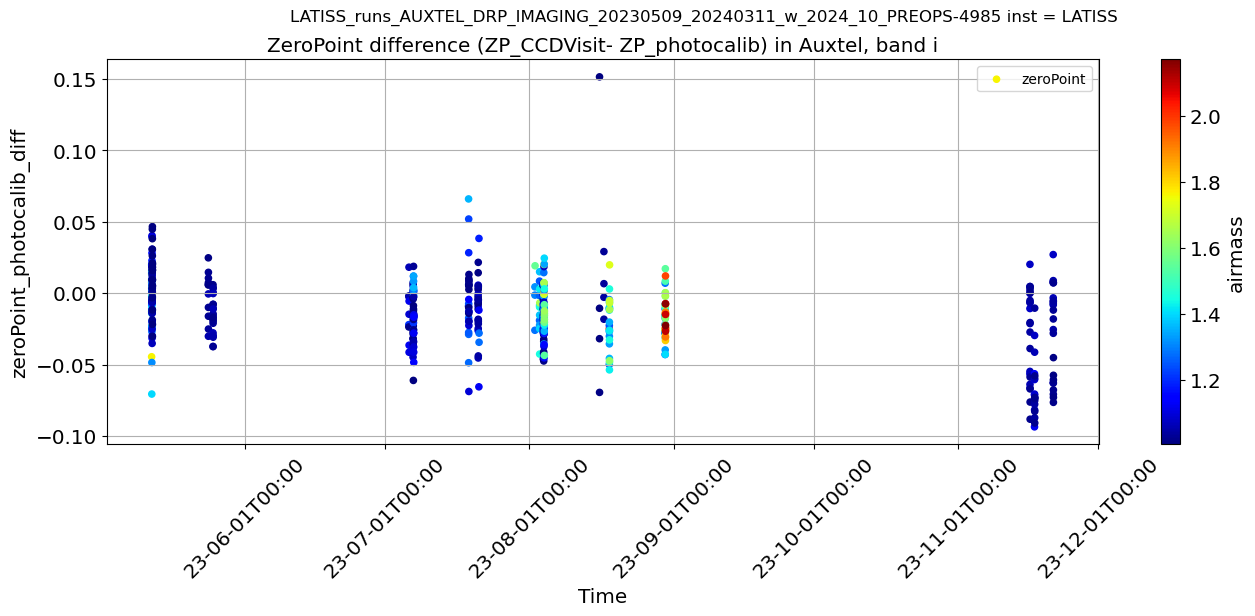

In [44]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band i"
df_i.plot.scatter(x="Time",y="zeroPoint_photocalib_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

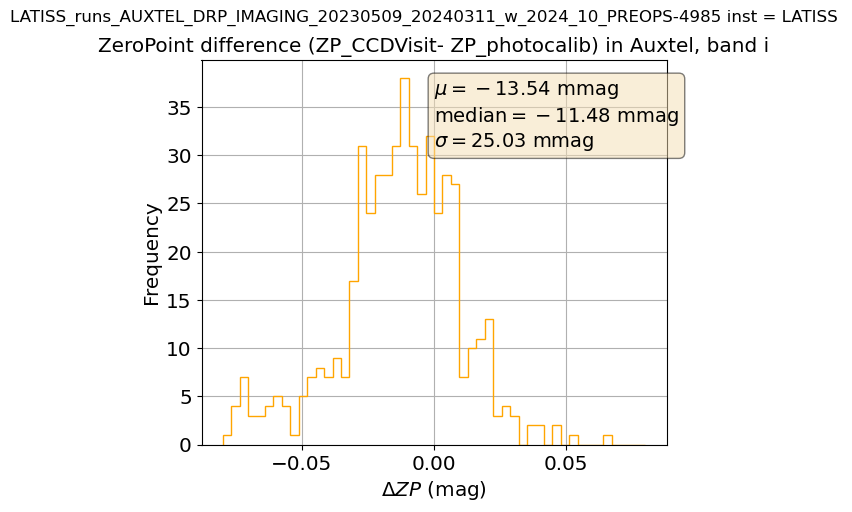

In [45]:
mu = df_i["zeroPoint_photocalib_diff"].mean()*1000
median = df_i["zeroPoint_photocalib_diff"].median()*1000
sigma = np.std(df_i["zeroPoint_photocalib_diff"].values-median)*1000
sigma_i = sigma
d_i= median

textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu, ),
    r'$\mathrm{median}=%.2f$ mmag' % (median, ),
    r'$\sigma=%.2f$ mmag' % (sigma, )))


fig, ax = plt.subplots(1,1,figsize=(6,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band i"
df_i["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.08,0.08),color='orange',histtype="step",ax=ax,xlabel="$\Delta ZP$ (mag)",title=title,grid=True)
#ax.set_title(title)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("$\Delta ZP$ (mag)")
plt.suptitle(suptitle)

### Zero point in z band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

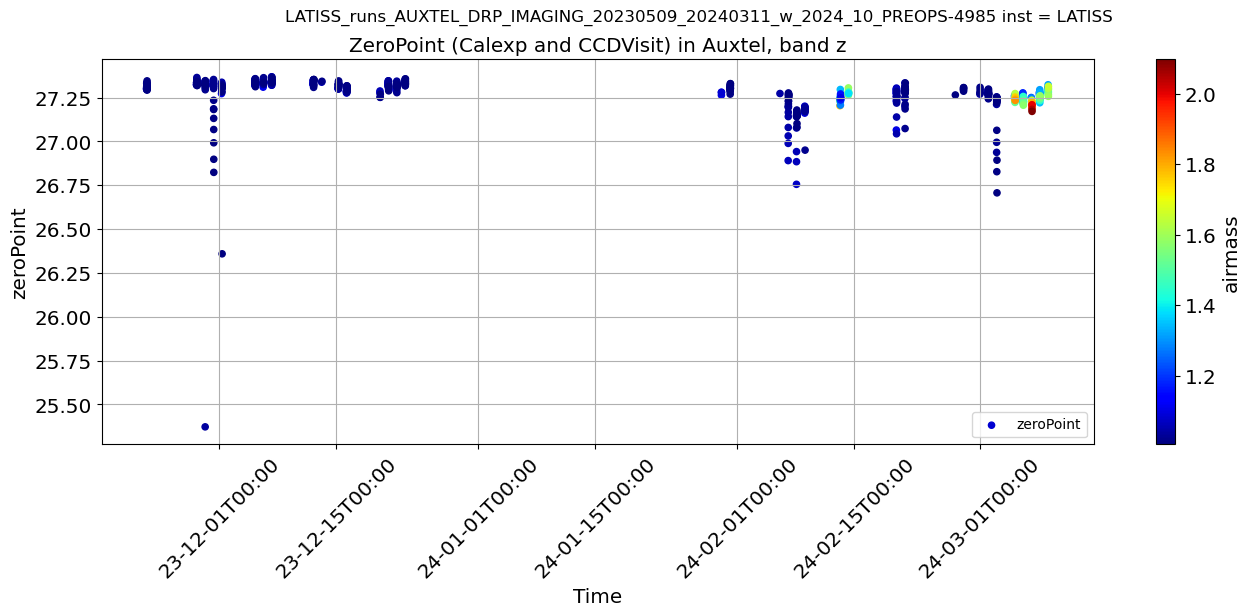

In [46]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint (Calexp and CCDVisit) in Auxtel, band z"
df_z.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
#df_r.plot.scatter(x="Time",y="magzero_dt",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,label="magzero_dt",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

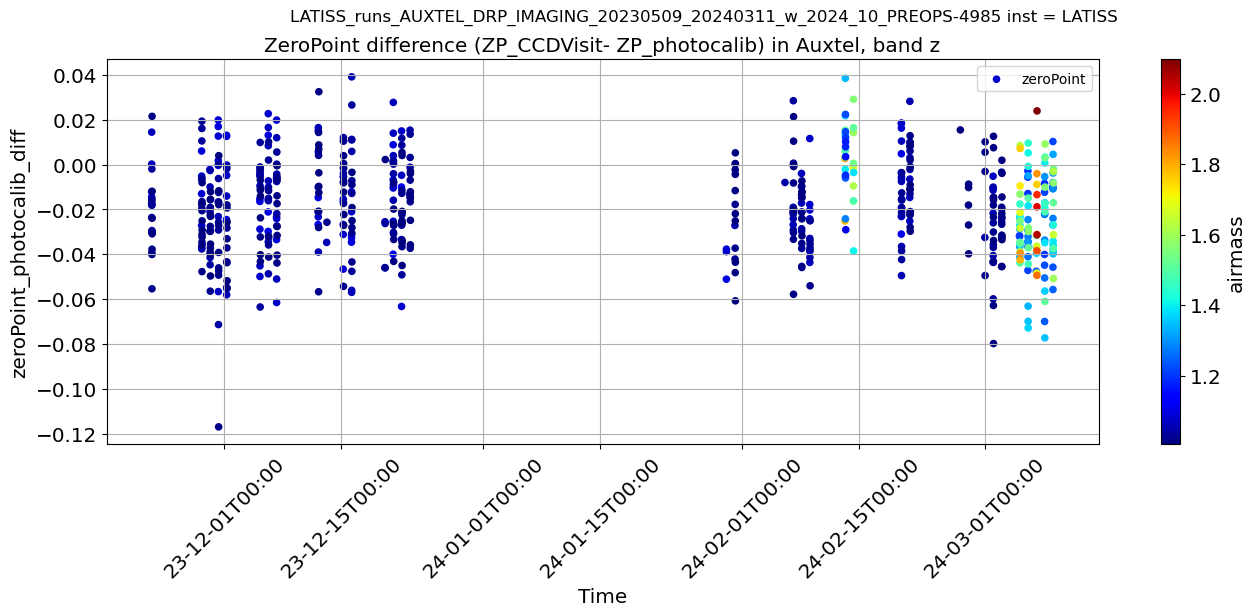

In [47]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band z"
df_z.plot.scatter(x="Time",y="zeroPoint_photocalib_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

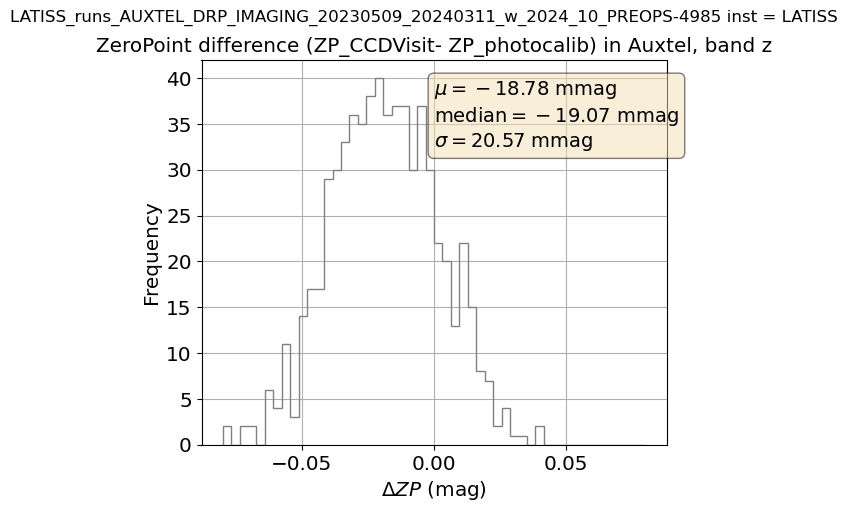

In [48]:
mu = df_z["zeroPoint_photocalib_diff"].mean()*1000
median = df_z["zeroPoint_photocalib_diff"].median()*1000
sigma = np.std(df_z["zeroPoint_photocalib_diff"].values-median)*1000
sigma_z = sigma
d_z= median
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu, ),
    r'$\mathrm{median}=%.2f$ mmag' % (median, ),
    r'$\sigma=%.2f$ mmag' % (sigma, )))


fig, ax = plt.subplots(1,1,figsize=(6,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band z"
df_z["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.08,0.08),color='grey',histtype="step",ax=ax,xlabel="$\Delta ZP$ (mag)",title=title,grid=True)
#ax.set_title(title)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("$\Delta ZP$ (mag)")
plt.suptitle(suptitle)

### Zero point in y band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

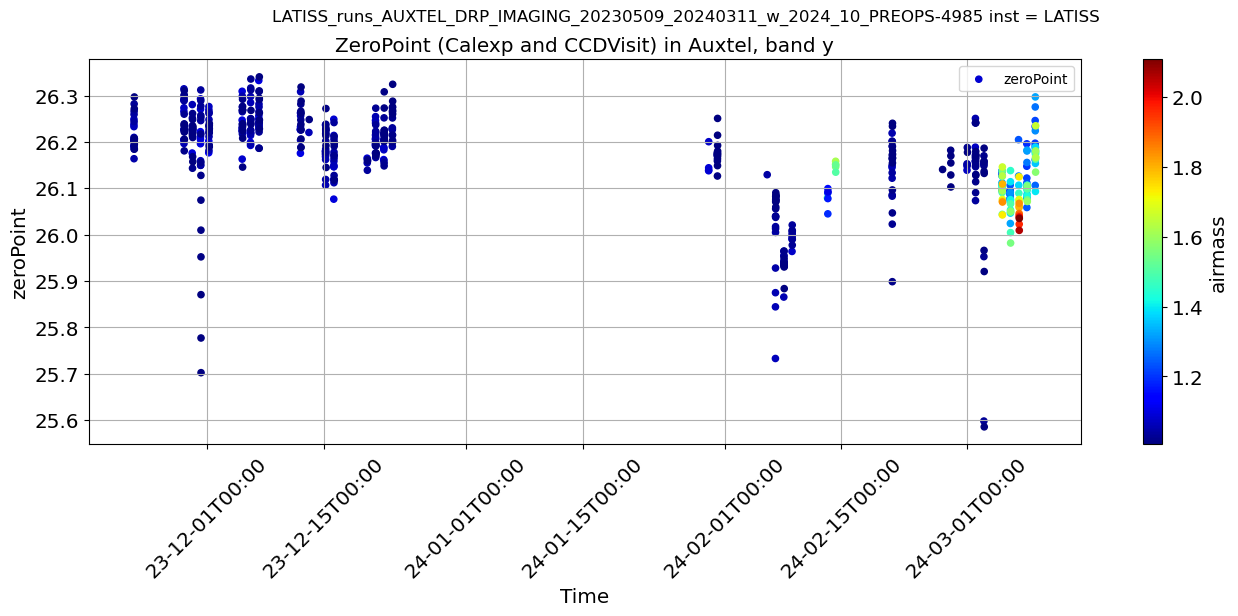

In [49]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint (Calexp and CCDVisit) in Auxtel, band y"
df_y.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
#df_r.plot.scatter(x="Time",y="magzero_dt",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,label="magzero_dt",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

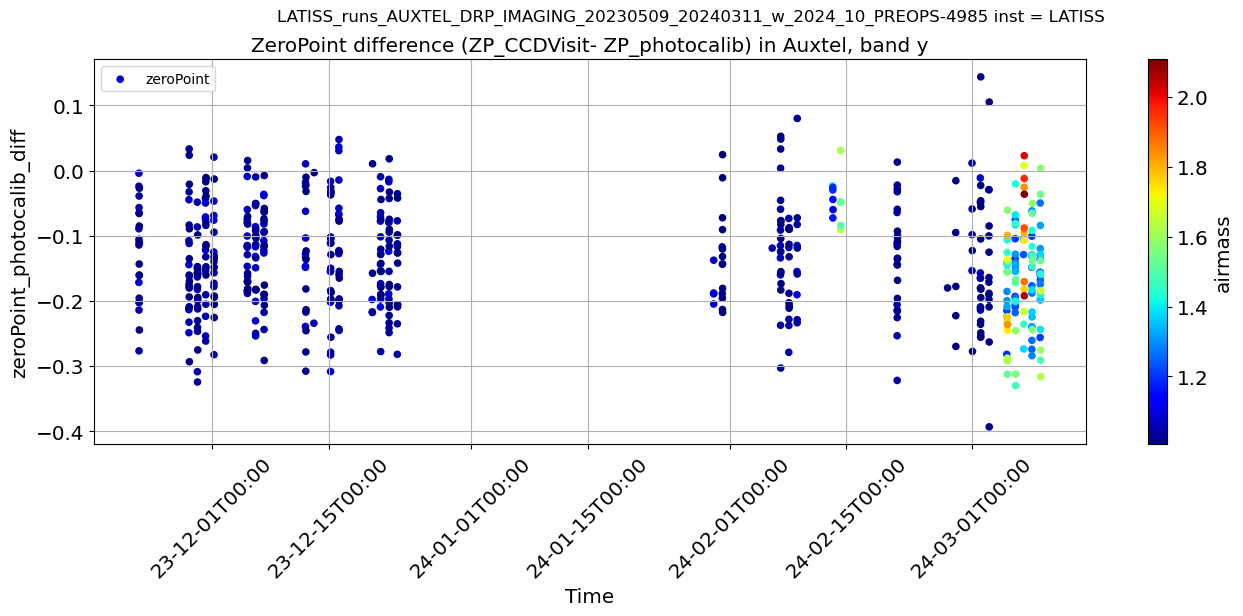

In [50]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band y"
df_y.plot.scatter(x="Time",y="zeroPoint_photocalib_diff",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,label="zeroPoint",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_title(title)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

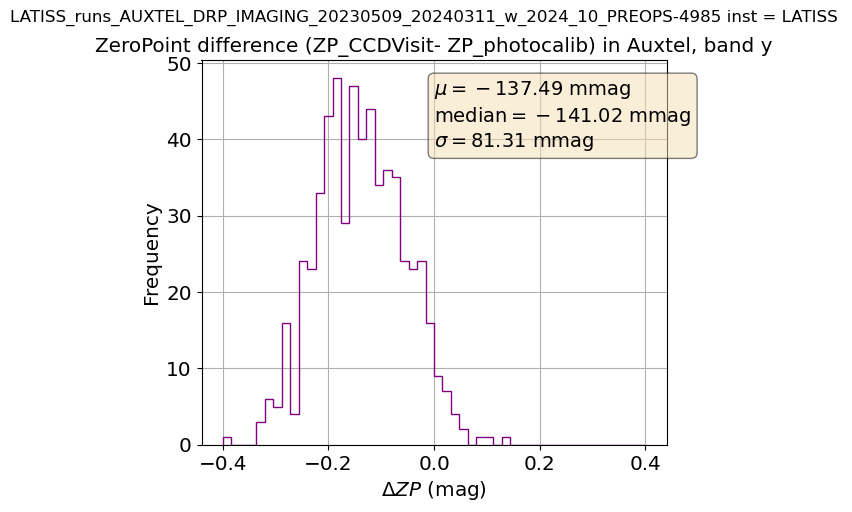

In [51]:
mu = df_y["zeroPoint_photocalib_diff"].mean()*1000
median = df_y["zeroPoint_photocalib_diff"].median()*1000
sigma = np.std(df_y["zeroPoint_photocalib_diff"].values-median)*1000
sigma_y = sigma
d_y= median

textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu, ),
    r'$\mathrm{median}=%.2f$ mmag' % (median, ),
    r'$\sigma=%.2f$ mmag' % (sigma, )))


fig, ax = plt.subplots(1,1,figsize=(6,5),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band y"
df_y["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.4,0.4),color='purple',histtype="step",ax=ax,xlabel="$\Delta ZP$ (mag)",title=title,grid=True)
#ax.set_title(title)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("$\Delta ZP$ (mag)")
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS ')

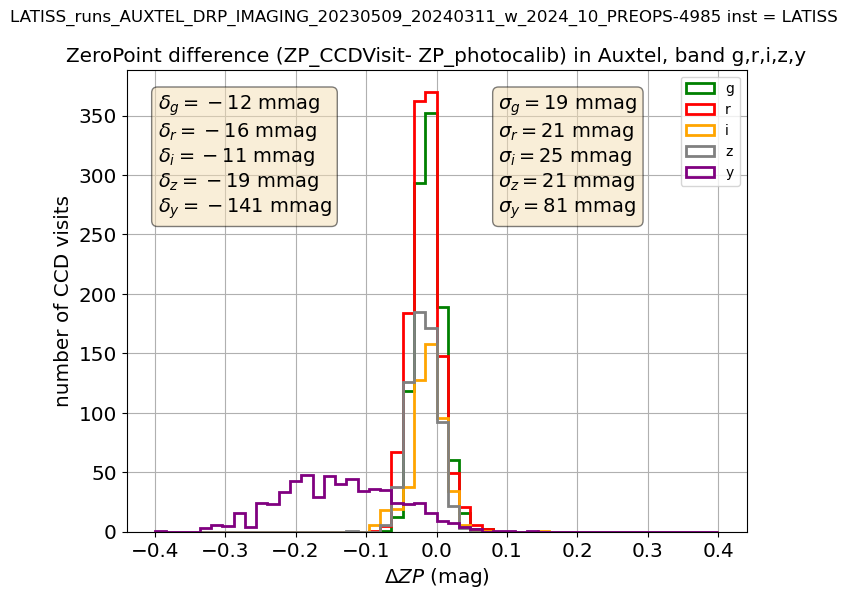

In [53]:
textstr = '\n'.join((
    r'$\sigma_g=%.0f$ mmag' % (sigma_g, ),
    r'$\sigma_r=%.0f$ mmag' % (sigma_r, ),
    r'$\sigma_i=%.0f$ mmag' % (sigma_i, ),
    r'$\sigma_z=%.0f$ mmag' % (sigma_z, ),
    r'$\sigma_y=%.0f$ mmag' % (sigma_y, )))

textstr2 = '\n'.join((
    r'$\delta_g=%.0f$ mmag' % (d_g, ),
    r'$\delta_r=%.0f$ mmag' % (d_r, ),
    r'$\delta_i=%.0f$ mmag' % (d_i, ),
    r'$\delta_z=%.0f$ mmag' % (d_z, ),
    r'$\delta_y=%.0f$ mmag' % (d_y, )))

fig, ax = plt.subplots(1,1,figsize=(8,6),sharex=False)
title = f"ZeroPoint difference (ZP_CCDVisit- ZP_photocalib) in Auxtel, band g,r,i,z,y"
df_g["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.4,0.4),color='g',histtype="step",ax=ax,label="g",xlabel="$\Delta ZP$ (mag)",title=title,grid=True,lw=2)
df_r["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.4,0.4),color='r',histtype="step",ax=ax,label="r",xlabel="$\Delta ZP$ (mag)",title=title,grid=True,lw=2)
df_i["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.4,0.4),color='orange',histtype="step",ax=ax,label="i",xlabel="$\Delta ZP$ (mag)",title=title,grid=True,lw=2)
df_z["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.4,0.4),color='grey',histtype="step",ax=ax,label="z",xlabel="$\Delta ZP$ (mag)",title=title,grid=True,lw=2)
df_y["zeroPoint_photocalib_diff"].plot.hist(bins=50,range=(-0.4,0.4),color='purple',histtype="step",ax=ax,label="y",xlabel="$\Delta ZP$ (mag)",title=title,grid=True,lw=2)
#ax.set_title(title)
ax.set_xlabel("$\Delta ZP$ (mag)")
ax.set_ylabel("number of CCD visits")
ax.legend()
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.05, 0.95, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.suptitle(suptitle)